In [1]:
import pandas as pd

In [3]:
trades = pd.read_csv('historical_data.csv')
fg = pd.read_csv('fear_greed_index.csv')

In [6]:
print(trades.head())
print(fg.head())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [8]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')

In [9]:
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], format='%d-%m-%Y %H:%M', errors='coerce')
trades['date'] = trades['timestamp_ist'].dt.date

In [10]:
trades['closed_pnl'] = pd.to_numeric(trades['closed_pnl'], errors='coerce')

In [11]:
if 'leverage' in trades.columns:
    trades['leverage'] = pd.to_numeric(trades['leverage'], errors='coerce')

In [12]:
fg['date'] = pd.to_datetime(fg['date']).dt.date
fg['value'] = pd.to_numeric(fg['value'], errors='coerce')

In [13]:
daily_perf = trades.groupby('date').agg(
    total_pnl = ('closed_pnl','sum'),
    avg_pnl = ('closed_pnl','mean'),
    num_trades = ('account','count'),
    win_rate = ('closed_pnl', lambda x: (x > 0).mean())
).reset_index()

In [14]:
df = daily_perf.merge(fg[['date','value','classification']], on='date', how='left')
df.rename(columns={'value':'fg_score'}, inplace=True)
df.head()

,date,total_pnl,avg_pnl,num_trades,win_rate,fg_score,classification
0,2023-05-01,0.000000,0.000000,3,0.000000,63.0,Greed
1,2023-12-05,0.000000,0.000000,9,0.000000,75.0,Extreme Greed
2,2023-12-14,-205.434737,-18.675885,11,0.363636,72.0,Greed
3,2023-12-15,-24.632034,-12.316017,2,0.000000,70.0,Greed
4,2023-12-16,0.000000,0.000000,3,0.000000,67.0,Greed


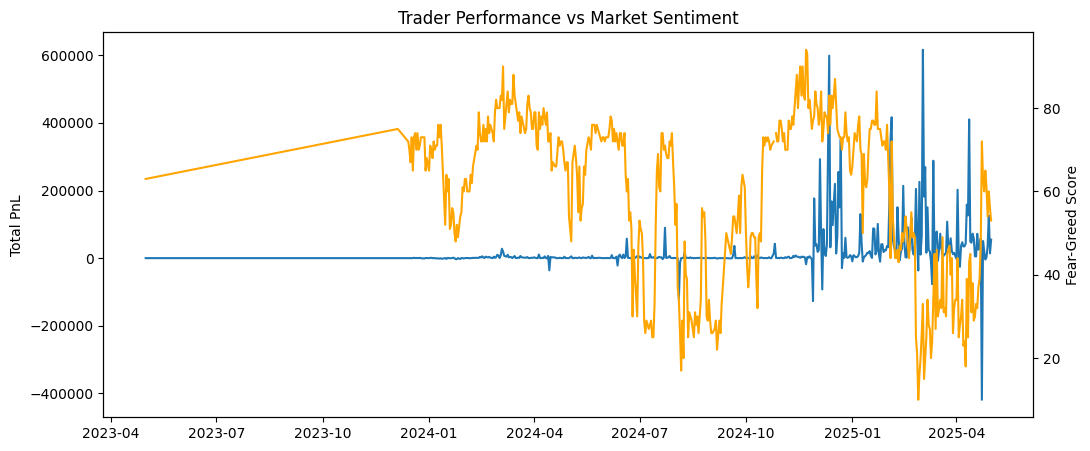

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df['date'], df['total_pnl'], label='Total PnL')
plt.ylabel('Total PnL')
ax2 = plt.twinx()
ax2.plot(df['date'], df['fg_score'], color='orange', label='Fear-Greed')
ax2.set_ylabel('Fear-Greed Score')
plt.title('Trader Performance vs Market Sentiment')
plt.show()


In [16]:
df[['total_pnl','fg_score']].corr()

,total_pnl,fg_score
total_pnl,1.000000,-0.082642
fg_score,-0.082642,1.000000


In [17]:
df.groupby('classification')['total_pnl'].mean().sort_values(ascending=False)

,total_pnl
classification,
Extreme Fear,52793.589178
Fear,36891.818040
Extreme Greed,23817.292199
Neutral,19297.323516
Greed,11140.566181


In [18]:
df.to_csv('trader_sentiment_analysis.csv', index=False)
from google.colab import files
files.download('trader_sentiment_analysis.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>